In [1]:
import pandas as pd
import keras_nlp
import numpy as np
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split

2024-07-30 23:38:38.159880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 23:38:38.235110: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 23:38:38.257043: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-30 23:38:38.398423: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-30 23:38:39.556910: W tensorflow/compiler/tf2

In [2]:
# Load Train Data
df = pd.read_csv('train.csv') 

# Take the first prompt and its associated response
df["prompt"] = df.prompt.map(lambda x: eval(x)[0])
df["response_a"] = df.response_a.map(lambda x: eval(x.replace("null","''"))[0])
df["response_b"] = df.response_b.map(lambda x: eval(x.replace("null", "''"))[0])

# Label conversion
label2name = {0: 'winner_model_a', 1: 'winner_model_b', 2: 'winner_tie'}
name2label = {v:k for k, v in label2name.items()}
df["class_name"] = df[["winner_model_a", "winner_model_b" , "winner_tie"]].idxmax(axis=1)
df["class_label"] = df.class_name.map(name2label)

# Show Sample
df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,class_name,class_label
0,30192,gpt-4-1106-preview,gpt-4-0613,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi...",1,0,0,winner_model_a,0
1,53567,koala-13b,gpt-4-0613,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,0,1,0,winner_model_b,1
2,65089,gpt-3.5-turbo-0613,mistral-medium,explain function calling. how would you call a...,Function calling is the process of invoking or...,Function calling is the process of invoking a ...,0,0,1,winner_tie,2
3,96401,llama-2-13b-chat,mistral-7b-instruct,How can I create a test set for a very rare ca...,Creating a test set for a very rare category c...,When building a classifier for a very rare cat...,1,0,0,winner_model_a,0
4,198779,koala-13b,gpt-3.5-turbo-0314,What is the best way to travel from Tel-Aviv t...,The best way to travel from Tel Aviv to Jerusa...,The best way to travel from Tel-Aviv to Jerusa...,0,1,0,winner_model_b,1


In [3]:
# Ensure all text data is encoded to UTF-8
df['prompt'] = df['prompt'].apply(lambda x: str(x).encode('utf-8', errors='ignore').decode('utf-8'))
df['response_a'] = df['response_a'].apply(lambda x: str(x).encode('utf-8', errors='ignore').decode('utf-8'))
df['response_b'] = df['response_b'].apply(lambda x: str(x).encode('utf-8', errors='ignore').decode('utf-8'))

In [4]:
df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,class_name,class_label
0,30192,gpt-4-1106-preview,gpt-4-0613,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi...",1,0,0,winner_model_a,0
1,53567,koala-13b,gpt-4-0613,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,0,1,0,winner_model_b,1
2,65089,gpt-3.5-turbo-0613,mistral-medium,explain function calling. how would you call a...,Function calling is the process of invoking or...,Function calling is the process of invoking a ...,0,0,1,winner_tie,2
3,96401,llama-2-13b-chat,mistral-7b-instruct,How can I create a test set for a very rare ca...,Creating a test set for a very rare category c...,When building a classifier for a very rare cat...,1,0,0,winner_model_a,0
4,198779,koala-13b,gpt-3.5-turbo-0314,What is the best way to travel from Tel-Aviv t...,The best way to travel from Tel Aviv to Jerusa...,The best way to travel from Tel-Aviv to Jerusa...,0,1,0,winner_model_b,1


In [5]:
# Load a preprocessor for Bert classification.
preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    preset = "bert_tiny_en_uncased",
    sequence_length = 512
)

I0000 00:00:1722357531.795195     822 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722357531.962300     822 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722357531.962397     822 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722357531.965904     822 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722357531.965995     822 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [6]:
def preprocess_fn(text, label=None):
    text = preprocessor(text)  # Preprocess text
    return (text, label) if label is not None else text  # Return processed text and label if available

In [7]:
def build_dataset(x1, x2, x3, label=None, batch_size=32, cache=True, shuffle=1024):
    AUTO = tf.data.AUTOTUNE
    slices = ((x1, x2, x3), ) if label is None else ((x1, x2, x3), keras.utils.to_categorical(label, num_classes=3))
    
    # Map labeled sentence pairs.
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.cache() if cache else ds  # Cache dataset if enabled
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)
    
    opt = tf.data.Options()  # Create dataset options
    if shuffle:
        ds = ds.shuffle(1024, seed=42)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)  # Set dataset options
    ds = ds.batch(batch_size, drop_remainder=False)  # Batch dataset
    ds = ds.prefetch(AUTO)  # Prefetch next batch

    return ds

In [8]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["class_label"])

In [9]:
# Build Train Dataset
x1_train = train_df['prompt'].tolist()
x2_train = train_df['response_a'].tolist()
x3_train = train_df['response_b'].tolist()
y_train = train_df['class_label'].tolist()
train_dataset = build_dataset(x1_train, x2_train, x3_train, 
                              label=y_train,
                              batch_size=32, 
                              shuffle=True)

# Build Validation Dataset
x1_val = val_df['prompt'].tolist()
x2_val = val_df['response_a'].tolist()
x3_val = val_df['response_b'].tolist()
y_val = val_df['class_label'].tolist()
validation_dataset = build_dataset(x1_val, x2_val, x3_val, 
                                   label=y_val,
                                   batch_size=16,
                                   shuffle=False)

# Modeling

In [10]:
# Load BERT backbone
backbone = keras_nlp.models.BertBackbone.from_preset("bert_tiny_en_uncased")
backbone.trainable = True

# Get the input and sequence output from BERT
inputs = backbone.input
sequence = backbone(inputs)["sequence_output"]

# Feature extraction
x = keras.layers.Dropout(0.2)(sequence)
x = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True))(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Attention()([x, x])

# Add a convolutional layer
x = keras.layers.Conv1D(filters=32, kernel_size=7, activation='relu')(x)
x = keras.layers.Conv1D(filters=32, kernel_size=7, activation='relu')(x)
x = keras.layers.MaxPooling1D(pool_size=2)(x)

# Reduce dimension
x = keras.layers.GlobalMaxPooling1D()(x)

# Add the output layer
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(3, activation='softmax')(x)

# Create the model
model = keras.Model(inputs, outputs)

# Summarize the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 128),     │  4,385,920 │ padding_mask[0][… │
│ (BertBackbone)      │ (None, None,      │            │ segment_ids[0][0… │
│                     │ 128)]             │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None, 128) │          0 │ bert_backbone[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, None, 128) │     98,816 │ dropout_2[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, None, 128) │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, None, 128) │          0 │ dropout_3[0][0],  │
│ (Attention)         │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, None, 32)  │     28,704 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, None, 32)  │      7,200 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, None, 32)  │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ max_pooling1d[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 32)        │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 3)         │         99 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,520,739 (17.25 MB)

 Trainable params: 4,520,739 (17.25 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# from tensorflow.keras.utils import plot_model

# # Plot the model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
# Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-6),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [13]:
# Suppress TensorFlow logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Clear GPU memory before training
tf.keras.backend.clear_session()

# Callbacks for early stopping and learning rate reduction
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=5e-8)

# Train the model with early stopping and learning rate reduction
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=32, callbacks=[early_stopping, reduce_lr])

Epoch 1/32


/home/dipp/.local/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
2024-07-30 23:39:13.511462: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1722357553.842995    1079 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722357553.878317    1079 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722357553.883076    1079 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722357553.888279    1079 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722357553.892043    1079 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 0

1436/1437 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.3421 - loss: 1.1481

W0000 00:00:1722357850.420505    1082 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722357850.422800    1082 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722357850.424783    1082 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722357850.426659    1082 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722357850.428605    1082 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722357850.430403    1082 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722357850.432237    1082 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722357850.434030    1082 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722357850.435905    1082 gp

1437/1437 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.3421 - loss: 1.1481

W0000 00:00:1722357852.602717    1089 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722357852.604794    1089 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722357852.606469    1089 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722357852.608143    1089 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722357852.609976    1089 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722357852.611799    1089 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722357852.613560    1089 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722357852.615559    1089 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722357852.617459    1089 gp

1437/1437 ━━━━━━━━━━━━━━━━━━━━ 357s 240ms/step - accuracy: 0.3421 - loss: 1.1481 - val_accuracy: 0.3657 - val_loss: 1.0945 - learning_rate: 5.0000e-06
Epoch 2/32
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 340s 236ms/step - accuracy: 0.3638 - loss: 1.0995 - val_accuracy: 0.3981 - val_loss: 1.0896 - learning_rate: 5.0000e-06
Epoch 3/32
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 326s 226ms/step - accuracy: 0.3850 - loss: 1.0897 - val_accuracy: 0.4077 - val_loss: 1.0835 - learning_rate: 5.0000e-06
Epoch 4/32
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 324s 225ms/step - accuracy: 0.4057 - loss: 1.0800 - val_accuracy: 0.4128 - val_loss: 1.0776 - learning_rate: 5.0000e-06
Epoch 5/32
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 323s 225ms/step - accuracy: 0.4175 - loss: 1.0749 - val_accuracy: 0.4184 - val_loss: 1.0736 - learning_rate: 5.0000e-06
Epoch 6/32
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 323s 224ms/step - accuracy: 0.4248 - loss: 1.0691 - val_accuracy: 0.4188 - val_loss: 1.0706 - learning_rate: 5.0000e-06
Epoch 7/32
1437/1437 ━━━━━━━━━━━━━━━━━━

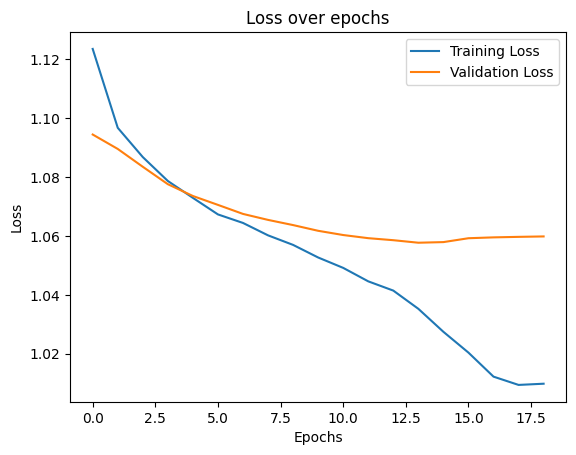

In [14]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict

In [19]:
test_df = pd.read_csv('test.csv')

# Take the first prompt and its associated response
test_df["prompt"] = test_df.prompt.map(lambda x: eval(x)[0])
test_df["response_a"] = test_df.response_a.map(lambda x: eval(x.replace("null","''"))[0])
test_df["response_b"] = test_df.response_b.map(lambda x: eval(x.replace("null", "''"))[0])

# Ensure all text data is encoded to UTF-8
test_df['prompt'] = test_df['prompt'].apply(lambda x: str(x).encode('utf-8', errors='ignore').decode('utf-8'))
test_df['response_a'] = test_df['response_a'].apply(lambda x: str(x).encode('utf-8', errors='ignore').decode('utf-8'))
test_df['response_b'] = test_df['response_b'].apply(lambda x: str(x).encode('utf-8', errors='ignore').decode('utf-8'))

test_df.head()

,id,prompt,response_a,response_b
0,136060,"I have three oranges today, I ate an orange ye...",You have two oranges today.,You still have three oranges. Eating an orange...
1,211333,You are a mediator in a heated political debat...,Thank you for sharing the details of the situa...,Mr Reddy and Ms Blue both have valid points in...
2,1233961,How to initialize the classification head when...,When you want to initialize the classification...,To initialize the classification head when per...


In [20]:
# Build Test Dataset
x1_test = test_df['prompt'].tolist()
x2_test = test_df['response_a'].tolist()
x3_test = test_df['response_b'].tolist()
test_dataset = build_dataset(x1_test, x2_test, x3_test, batch_size=32, shuffle=False)

In [21]:
test_pred = model.predict(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


# Submission

In [22]:
sub_df = test_df[["id"]].copy()
sub_df[list(label2name.values())] = test_pred.tolist()
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

,id,winner_model_a,winner_model_b,winner_tie
0,136060,0.303255,0.302340,0.394405
1,211333,0.417427,0.261254,0.321319
2,1233961,0.336496,0.354246,0.309258
